In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import os
import glob as gb
import cv2
import PIL
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau 
from keras.models import Sequential
from keras.layers import Conv2D , Dense , Dropout , Flatten , MaxPooling2D , BatchNormalization 
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow import keras
from keras.models import Model
import random
from sklearn.preprocessing import MinMaxScaler

In [2]:
import librosa.display
import IPython.display as ipd

In [3]:
path = 'ICBHI'


In [4]:
train = []
labels= []
train1=[]
files1=[]
for i in os.listdir(path):
    #entering train folder
    print("Entering to the folder name:",i)
    files=gb.glob(pathname=str(path+'/' + i + '/*.wav'))# pointing to all the .wav extension image folder
    print("Number of audio_files in the folder is",len(files))
    for j in files:
        # reading each audio file
        lung_sound ={'COPD':0,'Healthy':1 , 'Pneumonia' : 2}
        raw_data, sr = librosa.load(j,sr=None)
        train1.append(raw_data)
        train.append(raw_data)
        files1.append(j)
        labels.append(lung_sound[i])
        

Entering to the folder name: COPD
Number of audio_files in the folder is 94
Entering to the folder name: Healthy
Number of audio_files in the folder is 68
Entering to the folder name: Pneumonia
Number of audio_files in the folder is 74


In [5]:
train = np.array(train)
train1 = np.array(train1)
labels = np.array(labels)
type(train), train.shape, train1.shape
train1.shape


(236, 40000)

In [6]:
data = pd.DataFrame({
    "train" : list(train),
    "label" : labels
})
#data.drop(['train'] ,axis=1,inplace=True)
print(len(data))
data = data.sample(frac=1 , random_state=236)
len(data)
data.head()

236


,train,label
18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -3.0517578...",0
46,"[-3.0517578e-05, 0.0, 0.0, 0.0, -3.0517578e-05...",0
235,"[-0.049804688, -0.09509277, -0.07785034, -0.08...",2
108,"[-0.026733398, -0.055541992, -0.051879883, -0....",1
65,"[0.0, -3.0517578e-05, -3.0517578e-05, -3.05175...",0


In [7]:
train = np.array(data["train"])
labels = np.array(data["label"])
train[0] , labels[0]
#train.shape

(array([ 0.        ,  0.        ,  0.        , ..., -0.6773071 ,
        -0.6810913 , -0.68981934], dtype=float32),
 0)

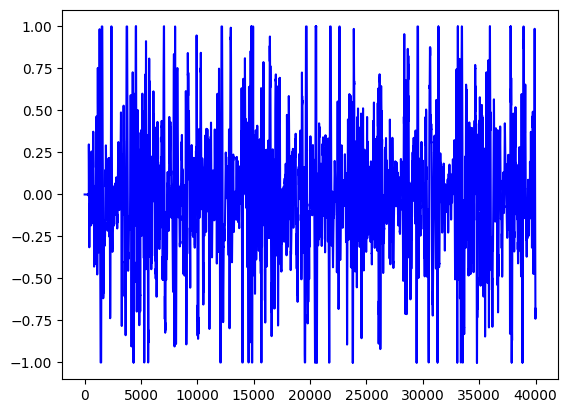

In [8]:
plt.plot(train[0], color="blue")

In [9]:

FRAME_SIZE = 1024
HOP_SIZE = 256
train_samples = []
test_samples = []

In [10]:
train_samples = []
for i in train:
    data = librosa.stft(i, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
    train_samples.append(data)
    
train_samples = np.array(train_samples)
    

In [11]:
train_samples.shape, train_samples[0][0][0]

((236, 513, 157), (-0.20389971+0j))

In [12]:

type(train_samples[0][0][0])
train_scale = np.abs(train_samples)
train_scale.shape

(236, 513, 157)

In [13]:
train_scale[0][0][0], type(train_scale[0][0][0])

(0.20389971, numpy.float32)

In [14]:
def plot_spectrogram(Y, sr, hop_length, i, y_axis="linear"):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis)
    plt.colorbar(format="%+2.f")

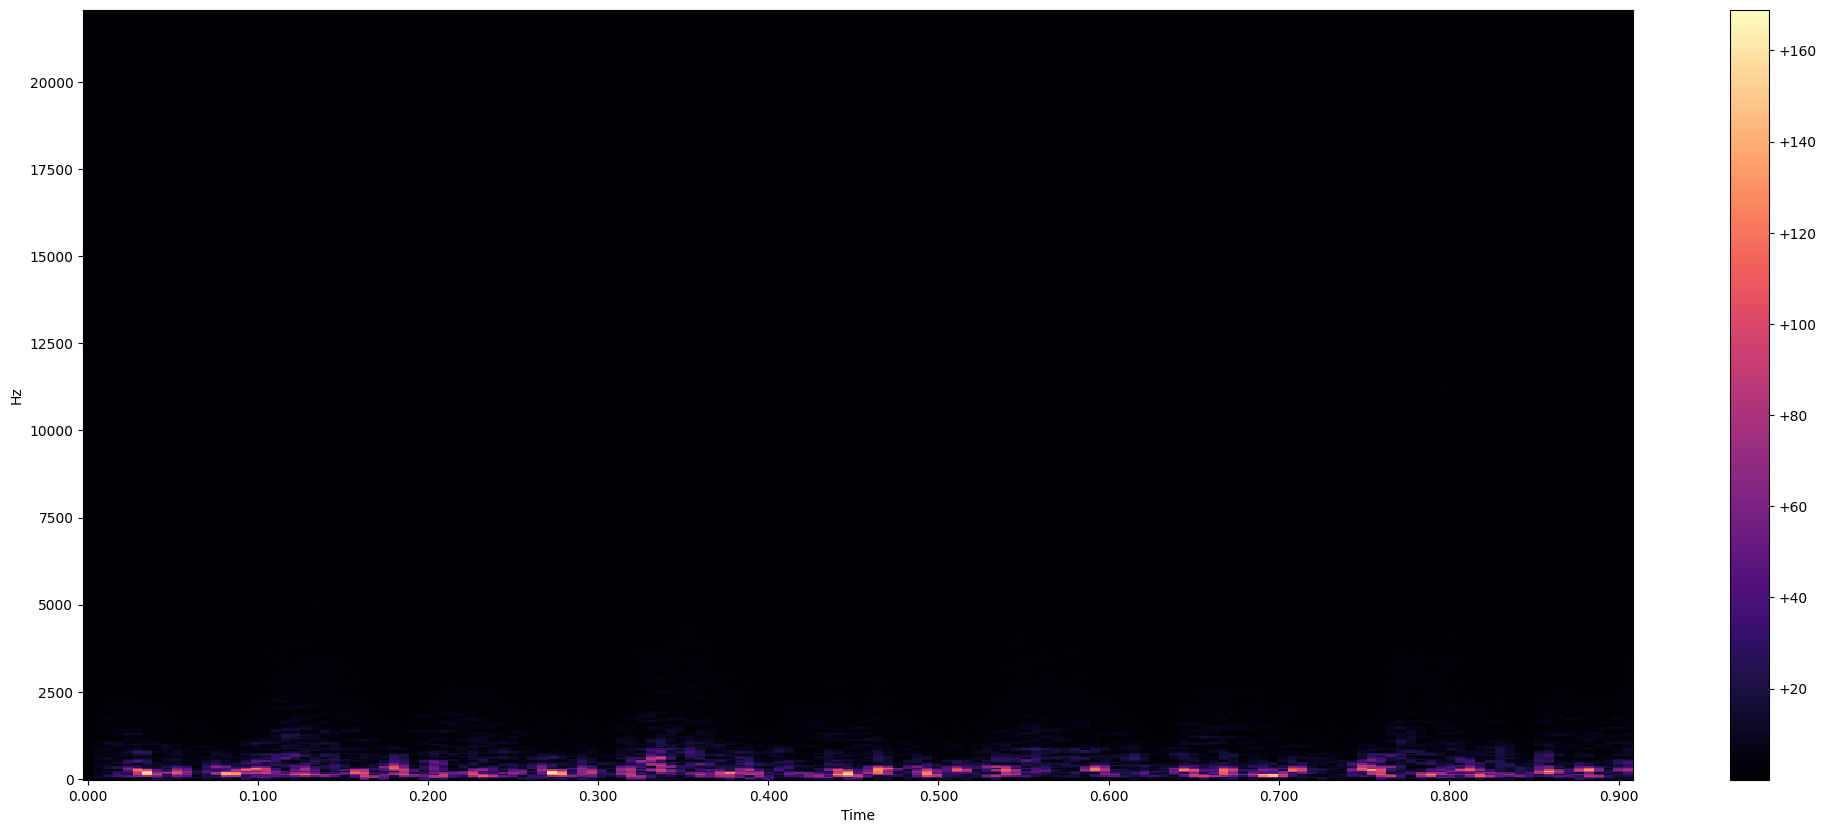

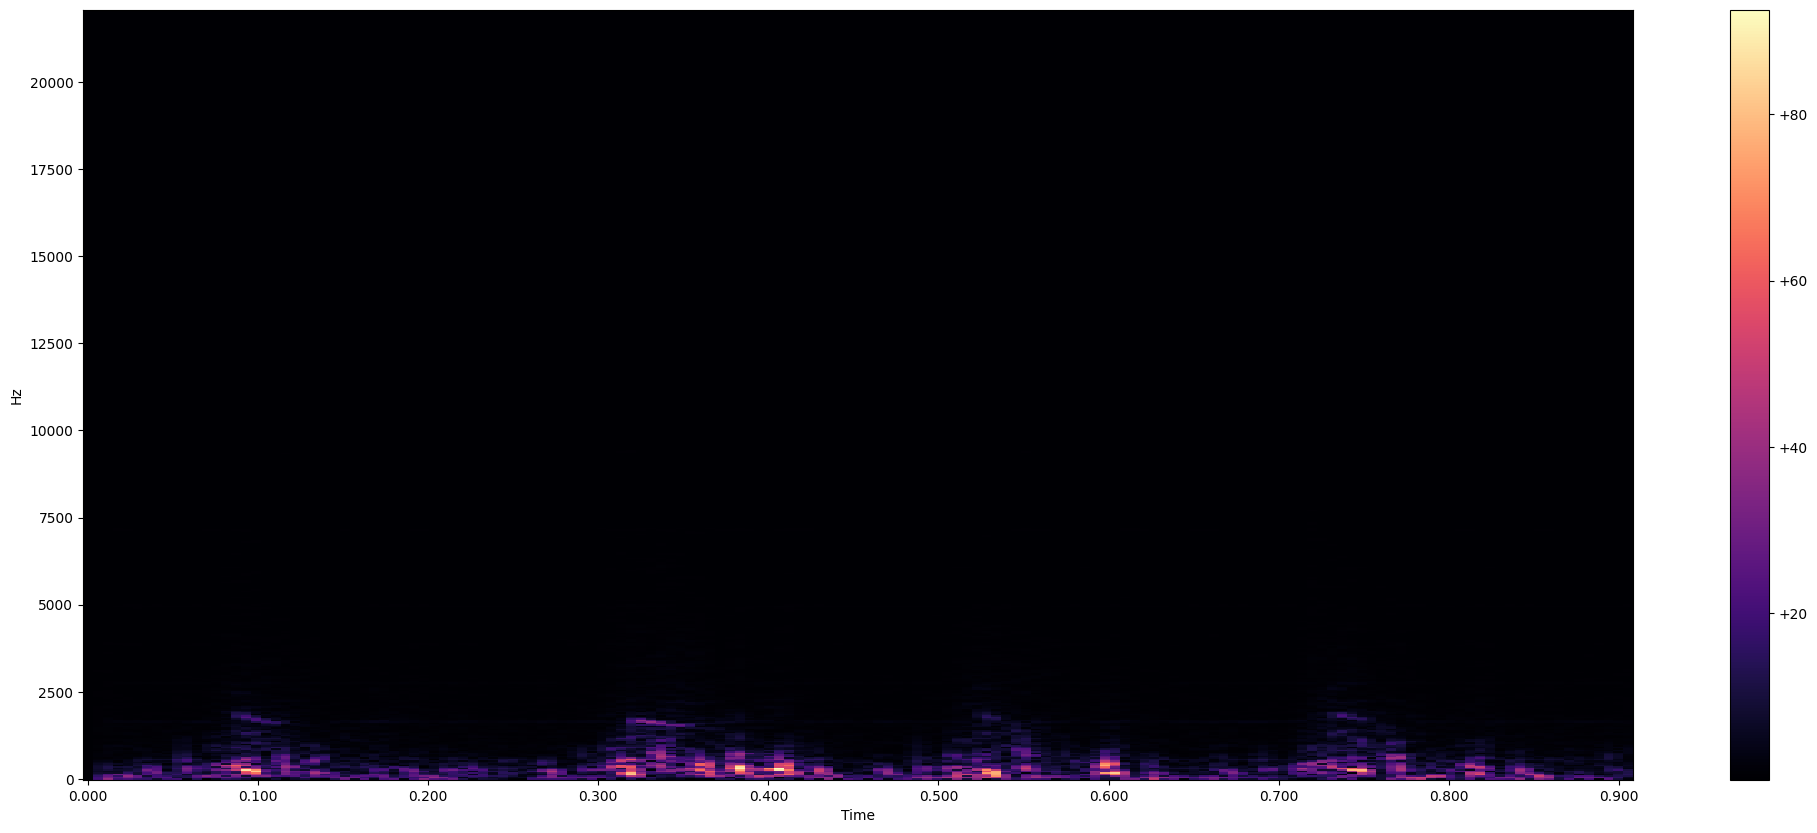

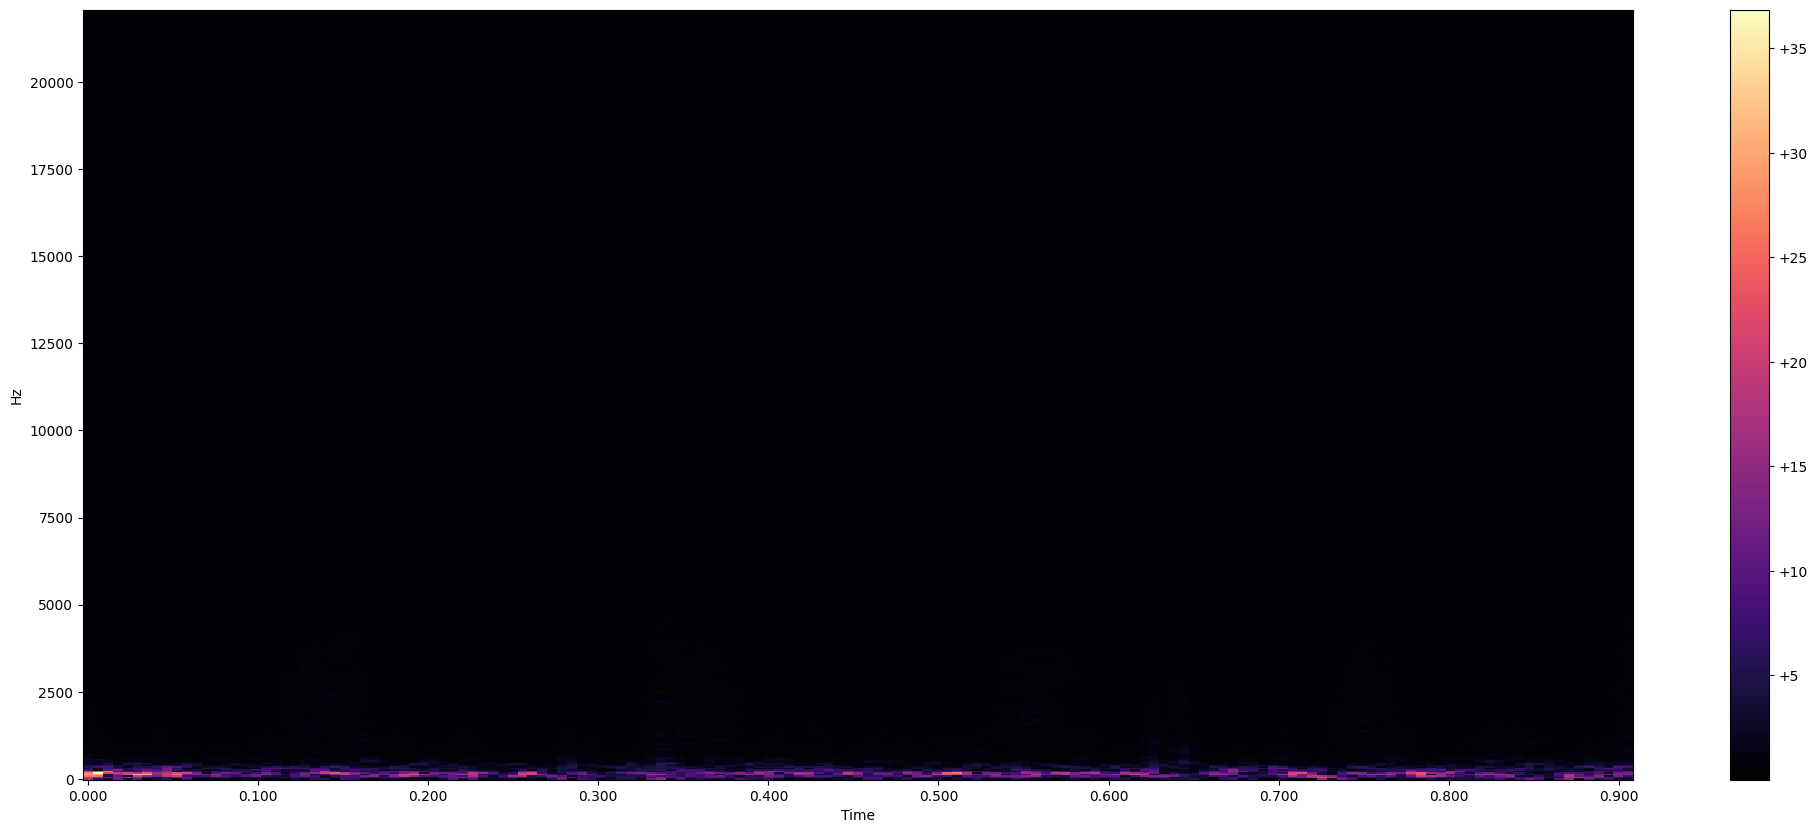

In [15]:
for i in range(3):
    plot_spectrogram(train_scale[i] , 44100, HOP_SIZE, i+1)

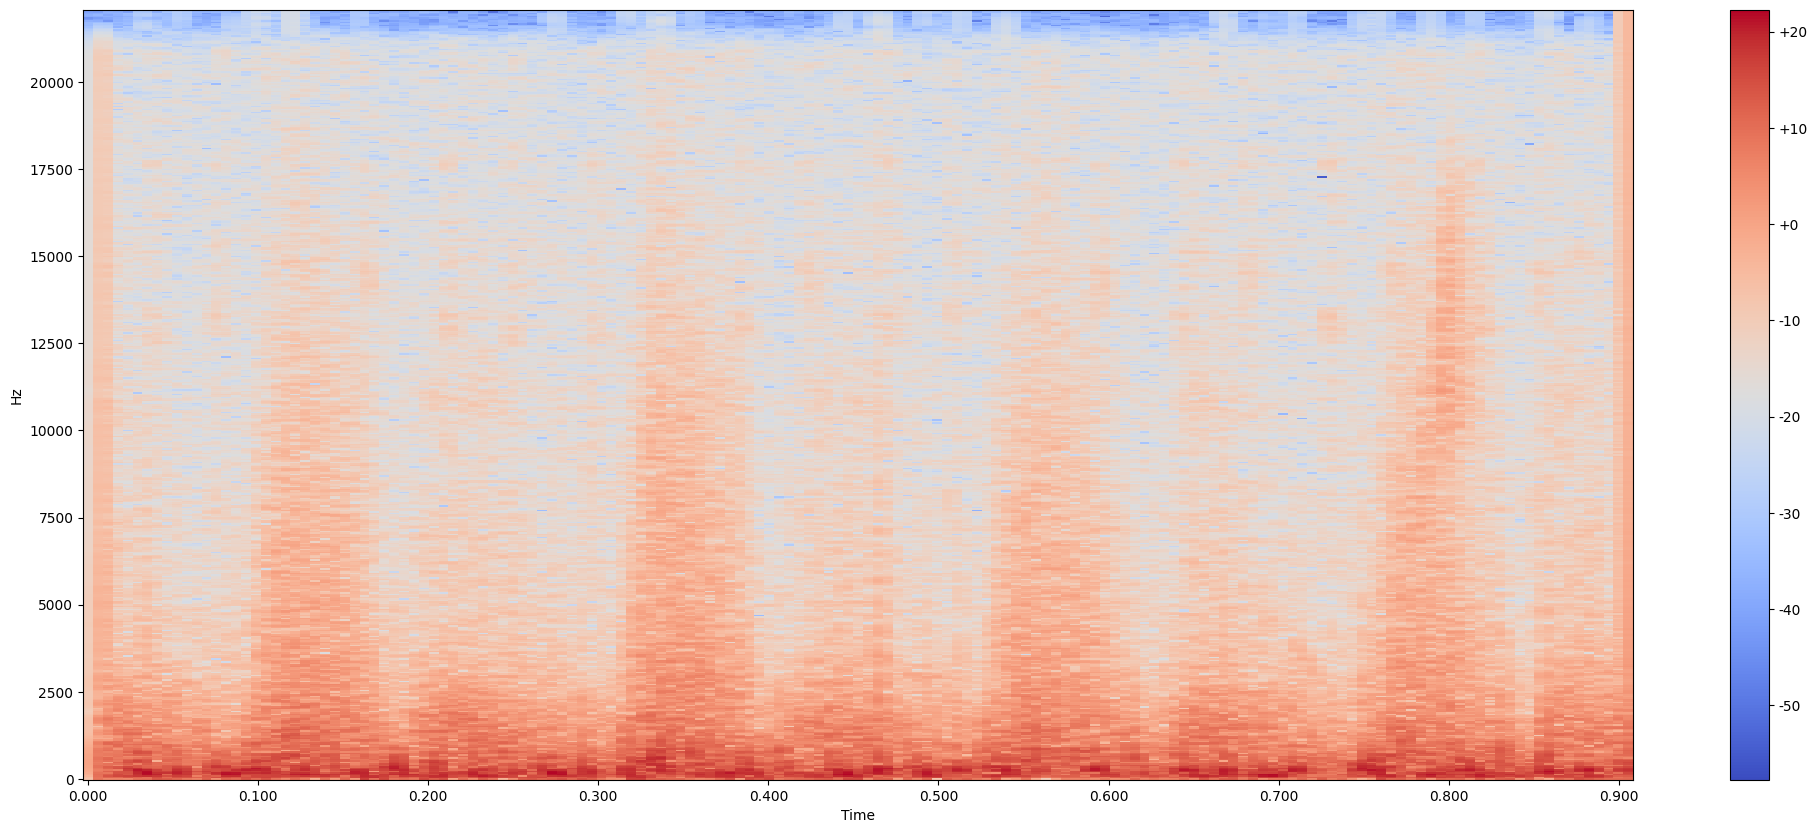

In [16]:
train_log = librosa.power_to_db(train_scale[0])
plot_spectrogram(train_log, 44100, HOP_SIZE, 0)

In [17]:
train_log[0][0], train_scale[0][0][0]

(-6.905834, 0.20389971)

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = []
for i in range(len(train_scale)):
    t = scaler.fit_transform(train_scale[i])
    X_train.append(t)

X_train = np.array(X_train)
X_train[0][0][0:10]

array([0.6577141 , 4.5721765 , 1.2876978 , 0.8773923 , 0.40779927,
       0.67406595, 0.53839964, 2.9707243 , 3.625222  , 1.165343  ],
      dtype=float32)

In [19]:
x_train,  x_test, Y_train, Y_test = train_test_split(X_train, labels, test_size=0.2, random_state=23, stratify=labels)

In [20]:
x_train.shape, Y_train.shape

((188, 513, 157), (188,))

In [21]:
x_train_cnn=x_train.reshape(-1,513, 157,1)
x_test_cnn = x_test.reshape(-1, 513, 157, 1)
x_train_cnn.shape , x_test_cnn.shape

((188, 513, 157, 1), (48, 513, 157, 1))

In [22]:
Y_train.shape, Y_test.shape, Y_test[:2]

((188,), (48,), array([2, 2]))

Using CNN model without hypertuning

In [23]:
from keras.layers import InputLayer

In [24]:
model1 = Sequential([
    InputLayer(shape=(513,157,1)),
    Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(1, 1)),
    Conv2D(16, kernel_size=(4, 4), strides=(2, 2), activation='relu'),
    MaxPooling2D(pool_size=(4, 4), strides=(2, 2)),
    Flatten(),
    Dense(8, activation='relu'),
    Dense(3, activation='softmax')
    
])
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 78, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 255, 77, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 126, 37, 16)    │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 17, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       134,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,475 (560.45 KB)

 Trainable params: 143,475 (560.45 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
Y_train.shape, Y_test.shape

((188,), (48,))

In [26]:
model1.compile(optimizer="Adam",
 loss='sparse_categorical_crossentropy',
 metrics=['accuracy'])

model_hisotry = model1.fit(x_train_cnn, Y_train, validation_data=(x_test_cnn, Y_test),  epochs=20, verbose=1, batch_size=10)


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.4011 - loss: 1.2969 - val_accuracy: 0.4167 - val_loss: 0.9903
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.5008 - loss: 0.9227 - val_accuracy: 0.6458 - val_loss: 0.9694
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.6424 - loss: 0.7904 - val_accuracy: 0.6458 - val_loss: 0.9796
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.6749 - loss: 0.7145 - val_accuracy: 0.6042 - val_loss: 0.9533
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.6845 - loss: 0.7485 - val_accuracy: 0.6667 - val_loss: 1.0247
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.7075 - loss: 0.6952 - val_accuracy: 0.6458 - val_loss: 1.0208
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.6873 - loss: 0.7402 - val_accuracy: 0.6667 - val_loss: 1.0272
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.7362 - loss: 0.6647 - val_accuracy: 0.

In [27]:
loss, accuracy =  model1.evaluate(x_test_cnn, Y_test, verbose= 1)
accuracy

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8368 - loss: 0.9973


0.8333333134651184

In [28]:
k = model1.predict(x_test_cnn)
k.shape

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step


(48, 3)

In [29]:
for i in model_hisotry.history:
    print(i, model_hisotry.history[i])

accuracy [0.3882978856563568, 0.563829779624939, 0.6382978558540344, 0.664893627166748, 0.686170220375061, 0.6755319237709045, 0.7021276354789734, 0.728723406791687, 0.7234042286872864, 0.728723406791687, 0.728723406791687, 0.7606382966041565, 0.7606382966041565, 0.75, 0.7393617033958435, 0.792553186416626, 0.792553186416626, 0.835106372833252, 0.8297872543334961, 0.8776595592498779]
loss [1.1505935192108154, 0.8651591539382935, 0.7915943264961243, 0.7554164528846741, 0.7422909140586853, 0.7090534567832947, 0.7010062336921692, 0.6774947643280029, 0.6581426858901978, 0.649452805519104, 0.6588638424873352, 0.6310495138168335, 0.6163825988769531, 0.6141785383224487, 0.6064786911010742, 0.5900138020515442, 0.5735495090484619, 0.5649057030677795, 0.554509162902832, 0.5387254953384399]
val_accuracy [0.4166666567325592, 0.6458333134651184, 0.6458333134651184, 0.6041666865348816, 0.6666666865348816, 0.6458333134651184, 0.6666666865348816, 0.6666666865348816, 0.6875, 0.6458333134651184, 0.6875,

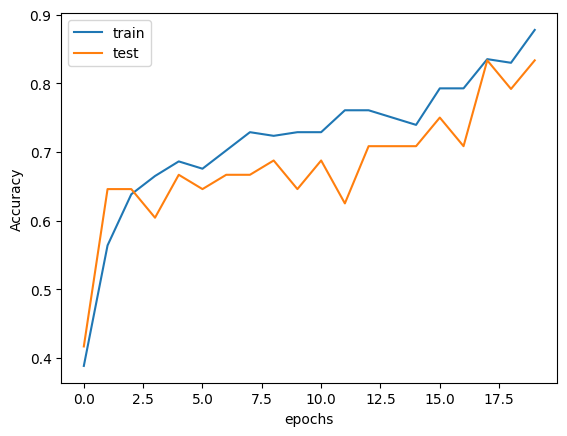

In [30]:
%matplotlib inline
plt.plot(model_hisotry.history["accuracy"])
plt.plot(model_hisotry.history["val_accuracy"])
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "test"], loc= "best")
plt.show()

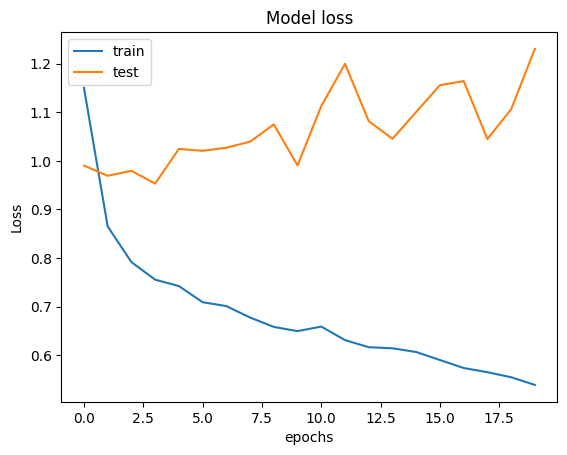

In [31]:
%matplotlib inline
plt.plot(model_hisotry.history["loss"])
plt.plot(model_hisotry.history["val_loss"])
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(["train", "test"], loc= "best")
plt.title("Model loss")
plt.show()

In [32]:

y_pred = model1.predict(x_test_cnn)
y_pred = np.argmax(y_pred, axis=1)
y_pred[:2], y_pred.shape



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


(array([2, 2], dtype=int64), (48,))

In [33]:
Y_test[:2]

array([2, 2])

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
rpt = classification_report(Y_test, y_pred)
print(rpt)

              precision    recall  f1-score   support

           0       0.90      0.95      0.92        19
           1       0.72      0.93      0.81        14
           2       0.90      0.60      0.72        15

    accuracy                           0.83        48
   macro avg       0.84      0.83      0.82        48
weighted avg       0.85      0.83      0.83        48



Text(58.222222222222214, 0.5, 'Truth')

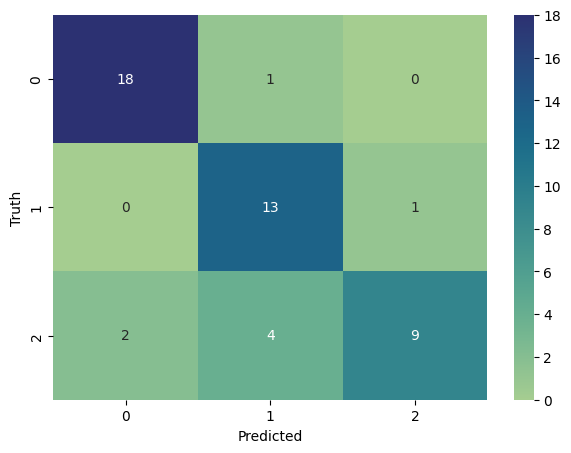

In [35]:
import seaborn as sn
cm = confusion_matrix(Y_test, y_pred)
%matplotlib inline
plt.figure(figsize=(7,5))
ax= sn.heatmap(cm, annot=True, cmap="crest")
plt.xlabel("Predicted")
plt.ylabel("Truth")
# ax.xaxis.set_ticklabels(["churn=no", "churn=yes"])
# ax.yaxis.set_ticklabels(["churn=no", "churn=yes"])

Applying the PCA on dataset

In [36]:
x_train.shape, Y_train.shape, x_test.shape, Y_test.shape

((188, 513, 157), (188,), (48, 513, 157), (48,))

In [37]:
from sklearn.decomposition import PCA
pca =PCA(0.98)
data_2d = np.array([features_2d.flatten() for features_2d in x_train])
pca.fit(data_2d)
x_train_pca = pca.transform(data_2d)
print("original shape:   ", data_2d.shape) 
print("transformed shape:", x_train_pca.shape)
data_2d1 = np.array([features_2d.flatten() for features_2d in x_test])
x_test_pca = pca.transform(data_2d1)
print("original shape:   ", data_2d1.shape) 
print("transformed shape:", x_test_pca.shape)

original shape:    (188, 80541)
transformed shape: (188, 102)
original shape:    (48, 80541)
transformed shape: (48, 102)


In [38]:
x_train_pca = x_train_pca.reshape(-1, 17, 6, 1)
x_test_pca = x_test_pca.reshape(-1, 17, 6, 1)

In [39]:
model2 = Sequential([
    InputLayer(shape=(17,6,1)),
    Conv2D(16, kernel_size=(2, 2), strides=(1, 1), activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(1, 1)),
    Flatten(),
    Dense(8, activation='relu'),
    Dense(3, activation='softmax')
    
])
model2.summary()
model2.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model2.fit(x_train_pca, Y_train, validation_data=(x_test_pca, Y_test), epochs=5, batch_size=10)
model2.evaluate(x_test_pca, Y_test)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 16, 5, 16)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 4, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         7,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,795 (30.45 KB)

 Trainable params: 7,795 (30.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.3600 - loss: 1.6038 - val_accuracy: 0.3542 - val_loss: 1.0922
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4200 - loss: 1.0666 - val_accuracy: 0.3333 - val_loss: 1.0806
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4171 - loss: 1.0356 - val_accuracy: 0.3333 - val_loss: 1.0484
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4732 - loss: 0.9794 - val_accuracy: 0.3542 - val_loss: 0.9977
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3942 - loss: 0.9872 - val_accuracy: 0.4375 - val_loss: 1.0086
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4271 - loss: 0.9932


[1.008618950843811, 0.4375]

Ranfom Forest Classifier

In [40]:
#Uisng Random forest classifier

x_train_ran = np.array([features_2d.flatten() for features_2d in x_train])
x_test_ran = np.array([features_2d.flatten() for features_2d in x_test])
x_train_ran.shape, x_test_ran.shape

((188, 80541), (48, 80541))

In [41]:
from sklearn.ensemble import RandomForestClassifier

model3 = RandomForestClassifier(n_estimators=100)
model3.fit(x_train_ran, Y_train)
model3.score(x_test_ran, Y_test)

0.9166666666666666

In [42]:
y_pred = model3.predict(x_test_ran)
y_pred[:3], Y_test[:3]

(array([2, 2, 1]), array([2, 2, 1]))

Text(58.222222222222214, 0.5, 'Truth')

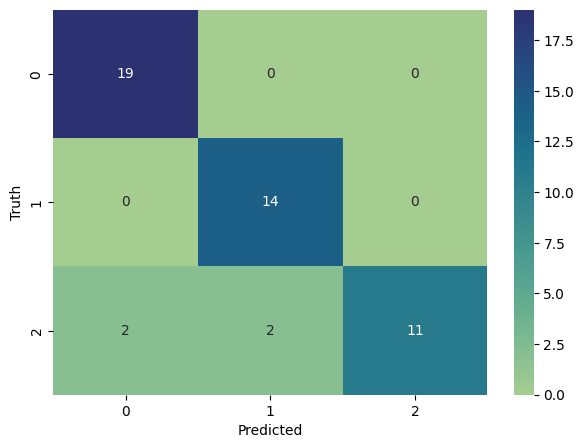

In [43]:
import seaborn as sn
cm = confusion_matrix(Y_test, y_pred)
%matplotlib inline
plt.figure(figsize=(7,5))
ax= sn.heatmap(cm, annot=True, cmap="crest")
plt.xlabel("Predicted")
plt.ylabel("Truth")

Using cnn model with Hypertuning

In [44]:
from keras_tuner import RandomSearch
from tensorflow import keras

In [52]:
def build_model(hp):
    hp_neurons = hp.Int('neurons', min_value = 8, max_value = 32, step = 8)
    hp_filters = hp.Int('filters', min_value = 8, max_value = 32, step = 8)
    model = Sequential([
    InputLayer(shape=(513,157,1)),
    Conv2D(filters=hp_filters, kernel_size=(3, 3), strides=(2, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(1, 1)),
    Conv2D(16, kernel_size=(4, 4), strides=(2, 2), activation='relu'),
    MaxPooling2D(pool_size=(4, 4), strides=(2, 2)),
    Flatten(),
    Dense(units=hp_neurons, activation='relu'),
    Dense(3, activation='softmax')])
    
    hp_learningrate = hp.Choice('learning_rate', values = [0.1,0.01, 0.001])
    hp_batchsize = hp.Choice("batch_size", [10,20,32])
    
    model.compile(optimizer = keras.optimizers.SGD(learning_rate=hp_learningrate), loss = "sparse_categorical_crossentropy", metrics =["accuracy"])
    
    return model
    
    

In [55]:
tuner = RandomSearch(
 build_model,
 objective='val_accuracy',
 max_trials=5,
 executions_per_trial=1,
 directory='keras_tuner_mnist',
 project_name='mnist_hyperparame'
 )
hp_batch_size = tuner.oracle.get_space()['batch_size']
tuner.search(x_train_cnn, Y_train,  epochs=20, validation_data=(x_test_cnn, Y_test), batch_size=hp_batch_size)

Trial 5 Complete [00h 00m 43s]
val_accuracy: 0.8333333134651184

Best val_accuracy So Far: 0.8958333134651184
Total elapsed time: 00h 03m 27s


In [56]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_neurons = best_hps.get('neurons')
best_filters = best_hps.get('filters')
best_learning_rate = best_hps.get('learning_rate')
best_batch_size = best_hps.get('batch_size')
print(f"Best number of neurons and fillters: {best_neurons,best_filters}")
print(f"Best learning rate: {best_learning_rate}")
print(f"Best batch size: {best_batch_size}")
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
# Evaluate the best model
loss, accuracy = best_model.evaluate(x_test_cnn, Y_test)
print(f"Test accuracy of the best model: {accuracy}")

Best number of neurons and fillters: (24, 24)
Best learning rate: 0.01
Best batch size: 20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.8993 - loss: 0.4859
Test accuracy of the best model: 0.8958333134651184


In [60]:
model_hisotry = best_model.fit(x_train_cnn, Y_train,  epochs=20, validation_data=(x_test_cnn, Y_test), batch_size=hp_batch_size)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9837 - loss: 0.1120 - val_accuracy: 0.8542 - val_loss: 0.5200
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9540 - loss: 0.1311 - val_accuracy: 0.8542 - val_loss: 0.5869
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9658 - loss: 0.0965 - val_accuracy: 0.7083 - val_loss: 1.1206
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9247 - loss: 0.2052 - val_accuracy: 0.8958 - val_loss: 0.6367
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.9267 - loss: 0.2736 - val_accuracy: 0.8750 - val_loss: 0.5955
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9468 - loss: 0.1599 - val_accuracy: 0.8958 - val_loss: 0.6149
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9866 - loss: 0.0782 - val_accuracy: 0.8750 - val_loss: 0.6972
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9867 - loss: 0.0588 - val_accuracy: 0.895

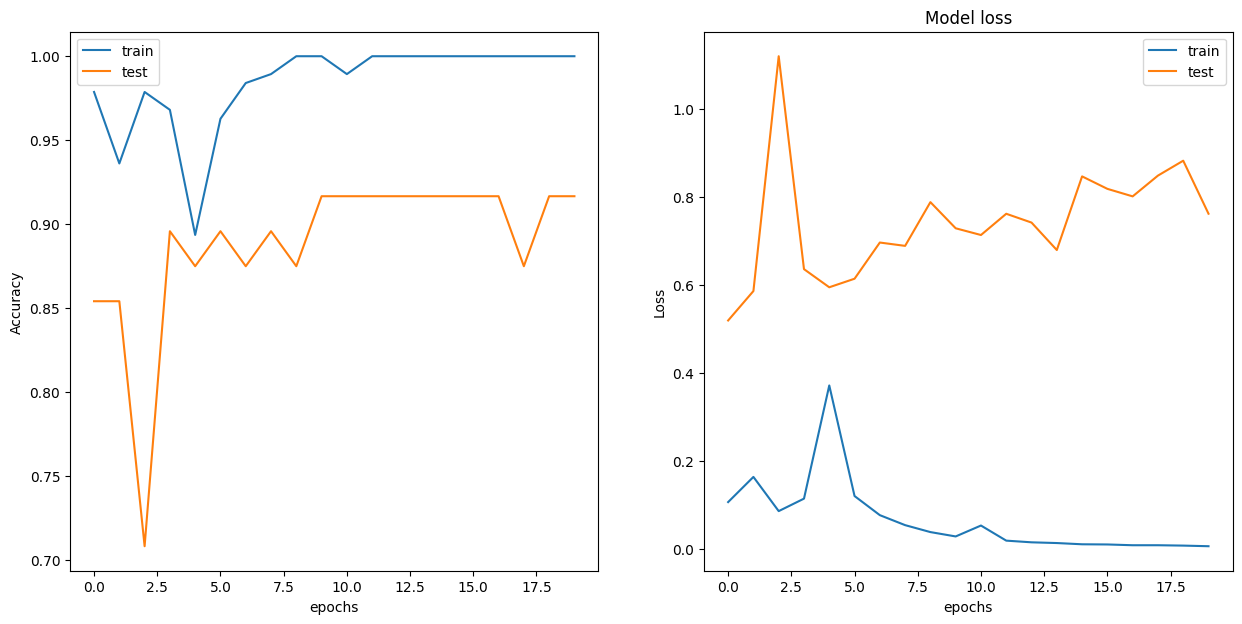

In [65]:
%matplotlib inline
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(model_hisotry.history["accuracy"])
plt.plot(model_hisotry.history["val_accuracy"])
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "test"], loc= "best")
plt.subplot(1,2,2)
plt.plot(model_hisotry.history["loss"])
plt.plot(model_hisotry.history["val_loss"])
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(["train", "test"], loc= "best")
plt.title("Model loss")
plt.show()

In [66]:
y_pred1 = best_model.predict(x_test_cnn)
y_pred1 = np.argmax(y_pred1, axis=1)
y_pred1[:2], Y_test[:2]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


(array([2, 2], dtype=int64), array([2, 2]))

We can see that cnn model with hyper tuning giving the best accuracy

In [67]:
print(classification_report(Y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        19
           1       0.88      1.00      0.93        14
           2       1.00      0.73      0.85        15

    accuracy                           0.92        48
   macro avg       0.93      0.91      0.91        48
weighted avg       0.93      0.92      0.91        48



Text(58.222222222222214, 0.5, 'Truth')

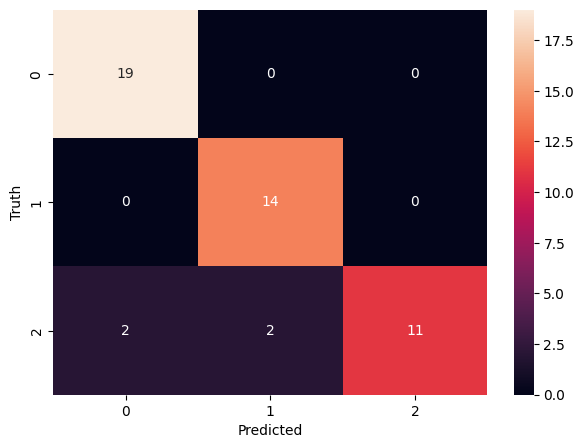

In [69]:
cm = confusion_matrix(Y_test, y_pred1)
%matplotlib inline
plt.figure(figsize=(7,5))
ax= sn.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")